In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, CSVLogger
from CinemaNet.train_utils import *
from CinemaNet.custom_head import *
from CinemaNet.wandb import *
from CinemaNet.MixMatch import *

import wandb

In [3]:
#hide
wandb.init(name='MM-MNet-2nd',
           project='shot-framing',
           tags=['MobileNetV2', 'MixMatch', 'fastai', 'PyTorch'],
           entity='synopsis',
           reinit=True)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


W&B Run: https://app.wandb.ai/synopsis/shot-framing/runs/gj6164s5

In [4]:
#hide
%env WANDB_NOTEBOOK_NAME='mixmatch-resnet.ipynb'

env: WANDB_NOTEBOOK_NAME='mixmatch-resnet.ipynb'


## Setup

In [5]:
path = Path('/home/rahul/github_projects/CinemaNet/')

In [6]:
config = wandb.config

config.img_size=to_film_ar(150)
config.batch_size=64
config.model='MobileNetV2'
config.mixup='True'
config.mixmatch='True'

Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


In [7]:
data = ImageDataBunch.from_folder(path, 
                                  train='valid', valid='train', # swapping train & valid datasets
                                  bs = config.batch_size,
                                  size = tuple(config.img_size),
                                  ds_tfms = get_transforms(max_zoom=1.),
                                  resize_method = ResizeMethod.SQUISH
                                 ).normalize(imagenet_stats) 

In [8]:
data.c
data

6

ImageDataBunch;

Train: LabelList (600 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Medium,Medium,Medium,Medium,Medium
Path: /home/rahul/github_projects/CinemaNet;

Valid: LabelList (5505 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Medium,Medium,Medium,Medium,Medium
Path: /home/rahul/github_projects/CinemaNet;

Test: None

In [9]:
data_unlabelled = ImageList.from_folder(path/'filmgrab')
data_unlabelled

ImageList (95329 items)
Image (3, 576, 1024),Image (3, 576, 1024),Image (3, 576, 1024),Image (3, 576, 1024),Image (3, 576, 1024)
Path: /home/rahul/github_projects/CinemaNet/filmgrab

In [10]:
config.valid_size = len(data.valid_ds)
config.train_size = len(data.train_ds)
config.unlabelled_size = len(data_unlabelled)

Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


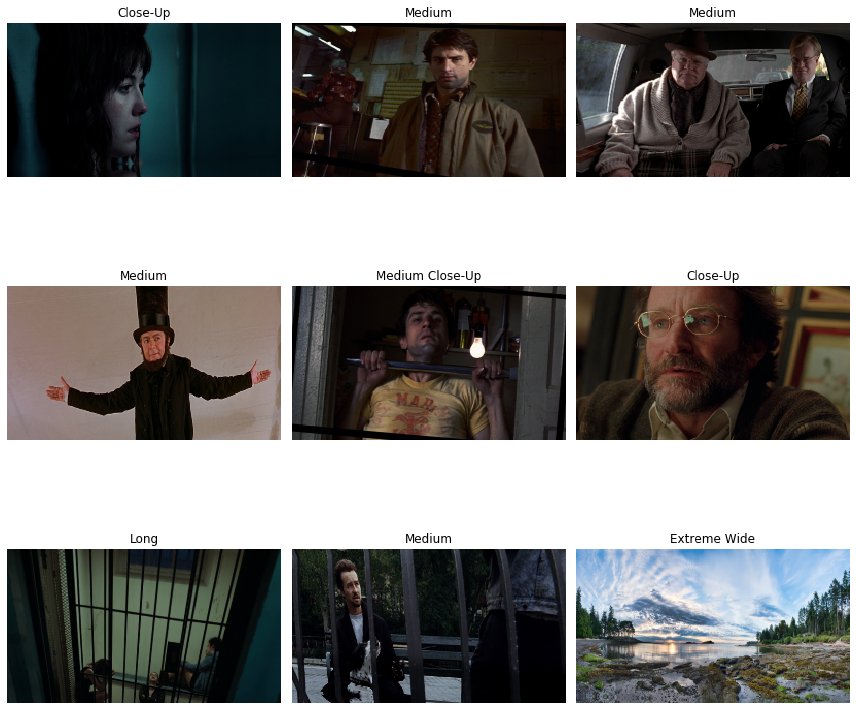

In [11]:
data.show_batch(rows=3)

## MixMatch

In [11]:
arch = models.mobilenet_v2
learn = cnn_learner(data, arch, pretrained=True, metrics=metrics).mixmatch(data_unlabelled, α=.75, λ=75, size=config.img_size)

In [12]:
learn.data

ImageDataBunch;

Train: MultiTfmLabelList (95329 items)
x: ImageList
[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)]
y: EmptyLabelList
,,,,
Path: /home/rahul/github_projects/CinemaNet/filmgrab;

Valid: LabelList (5505 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Medium,Medium,Medium,Medium,Medium
Path: /home/rahul/github_projects/CinemaNet;

Test: None

labeled dataset     :           600 samples
unlabeled dataset   :        95,329 samples
total train samples :       285,888 samples


epoch,train_loss,valid_loss,accuracy,precision,recall,train_Lx,train_Lu*λ,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


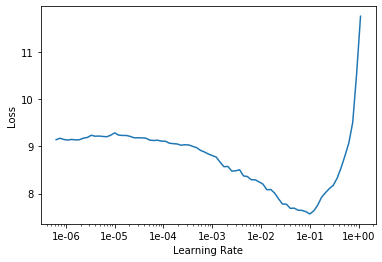

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
def get_callbacks(learner, mod_name, early_stop=True, patience=5, monitor='accuracy', min_delta=0.01):
    callbacks=[
        SaveModelCallback(learner, every='epoch', name=f'{mod_name}', monitor=monitor),
        #SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_val_loss', monitor='valid_loss'),
        #SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_accuracy', monitor='accuracy')
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images', log='all')
    ]
    if early_stop: callbacks.append(EarlyStoppingCallback(learner, patience=patience, min_delta=min_delta, monitor=monitor))
    return callbacks

In [15]:
model_name = 'MobileNetV2-img_150-MixMatch_run2'

# log every epoch -- sometimes, minor improvements in valid_loss/accuracy come with a massive
# drop in train_loss, which IMO is sub-optimal. It's better to pick up training from a point
# where both train and valid loss are not too low and then unfreeze and retrain
callbacks = get_callbacks(learn, model_name, patience=4, monitor='valid_loss')

In [16]:
torch.cuda.empty_cache()

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.298844,1.132890,0.570391,0.671936,0.580231,00:56
1,1.443870,1.381527,0.666848,0.732718,0.684233,00:55
2,1.073909,1.096716,0.751317,0.768561,0.750544,01:00
3,0.816823,0.972636,0.761308,0.768581,0.778614,00:58
4,0.648435,0.933127,0.757856,0.773752,0.768120,00:57
5,0.515099,0.848420,0.773115,0.780494,0.782555,00:58
6,0.428406,0.828288,0.772389,0.779007,0.781423,00:56


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with valid_loss value: 1.1328904628753662.
Better model found at epoch 2 with valid_loss value: 1.0967158079147339.
Better model found at epoch 3 with valid_loss value: 0.9726364612579346.
Better model found at epoch 4 with valid_loss value: 0.9331267476081848.
Better model found at epoch 5 with valid_loss value: 0.8484202027320862.
Better model found at epoch 6 with valid_loss value: 0.8282880187034607.
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200118_041546-gj6164s5/bestmodel.pth


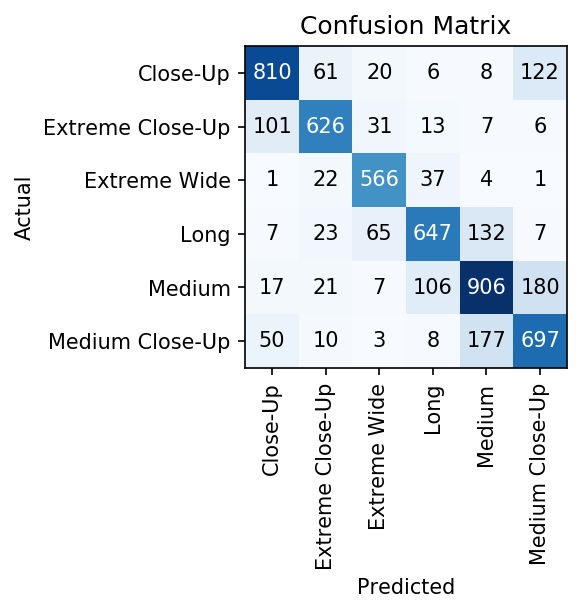

In [17]:
learn.fit_one_cycle(7, 3e-3, callbacks=callbacks)

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


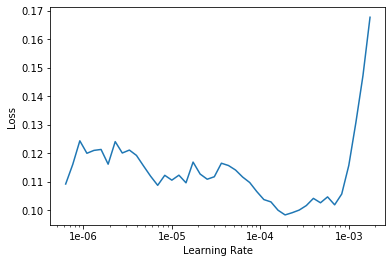

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
model_name = 'MobileNetV2-img_150-MixMatch_run2-unfrozen'
callbacks = get_callbacks(learn, model_name, patience=4, monitor='valid_loss')

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.103431,0.815784,0.774205,0.778768,0.785196,00:52
1,0.111778,0.795531,0.778565,0.783018,0.791013,00:56
2,0.105677,0.784405,0.783288,0.786519,0.795238,00:55
3,0.097163,0.807384,0.783651,0.786088,0.796328,00:56
4,0.087906,0.807095,0.786739,0.788313,0.800332,00:59
5,0.081791,0.810830,0.784741,0.787047,0.798715,00:57
6,0.076826,0.807196,0.788556,0.790546,0.803328,00:56


Better model found at epoch 0 with valid_loss value: 0.8157838582992554.


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


Better model found at epoch 1 with valid_loss value: 0.7955309748649597.
Better model found at epoch 2 with valid_loss value: 0.784404993057251.
Epoch 7: early stopping
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200118_041546-gj6164s5/bestmodel.pth


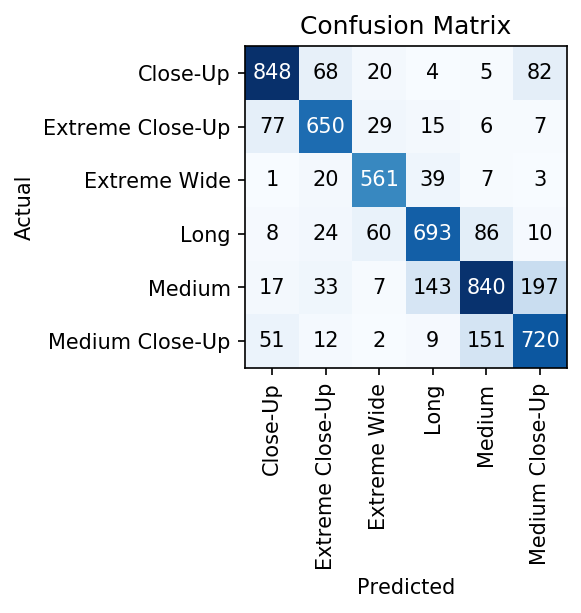

In [21]:
learn.fit_one_cycle(10, 5e-5, callbacks=callbacks)